# Loading GeoTiffs

In [1]:
import starepandas
import rasterio
import numpy
import geopandas
import pyproj
import pystare

## Usage

In [2]:
file_path = '../tests/data/wind.tif'

In [10]:
sdf = starepandas.read_geotiff(file_path, add_pts=True, add_latlon=True, 
                               add_xy=True, add_trixels=True)

<AxesSubplot:>

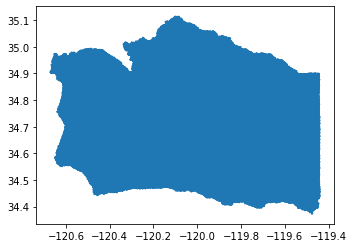

In [11]:
sdf.plot()

## Detail:

This is a geotiff containing average wind speeds in Santa Barbara county. It is projected in California Albers (EPSG:3310).
Note that the raster is clipped to the county outline, thus containing NaNs

In [4]:
with rasterio.open(file_path) as src:
    values = {}
    for band in range(1, src.count+1):        
        values[f'band_{band}'] = src.read(band)
    height = values['band_1'].shape[0]
    width = values['band_1'].shape[1]    
    cols, rows = numpy.meshgrid(numpy.arange(width), numpy.arange(height))
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    xs = numpy.array(xs)
    ys = numpy.array(ys)
    src_crs = src.crs

In [24]:
dst_crs = 'EPSG:4326'
transformer = pyproj.Transformer.from_crs(src_crs, dst_crs)
lats, lons = transformer.transform(xs, ys)
sids = pystare.from_latlon_2d(lats, lons, adapt_level=True)

In [17]:
for key in values:
    values[key] = values[key].flatten()

In [19]:
pts = geopandas.points_from_xy(lons.flatten(), lats.flatten())
gdf = geopandas.GeoDataFrame(values, geometry=pts, crs=dst_crs)
gdf = starepandas.STAREDataFrame(gdf, sids=sids.flatten())
gdf.dropna(inplace=True)
gdf.reset_index(inplace=True, drop=True)

In [20]:
gdf.to_file('wind.gpkg', driver='GPKG')

In [21]:
gdf

,band_1,geometry,sids
0,5.663013,POINT (-120.10227 35.11179),3331805789998083439
1,5.951427,POINT (-120.09952 35.11180),3331806038636011599
2,5.996681,POINT (-120.09403 35.11180),3331806067856073871
3,6.070150,POINT (-120.09129 35.11180),3331806068042513903
4,6.267935,POINT (-120.08854 35.11180),3331806068981832655
...,...,...,...
105754,2.487919,POINT (-119.47862 34.38096),3331781606735464335
105755,2.377520,POINT (-119.47590 34.38094),3331781546799927631
105756,2.511101,POINT (-119.47863 34.37870),3331781608685226255
105757,2.365220,POINT (-119.47591 34.37869),3331781608519480815
